In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
#from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout, MaxPooling2D
#from tensorflow.keras.applications import mobilenet_v2
#from tensorflow.keras.models import Model
#from PIL import Image

In [2]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Load Model

In [3]:
model = keras.models.load_model('models/model_cnn_mobilenet_6.h5')

2021-12-01 14:27:38.769606: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

# Data Generator

In [5]:
datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, fill_mode='nearest')
testgen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = datagen.flow_from_directory(
    'human/train',  
    target_size=(224, 224), 
    batch_size=32,
    seed=11,
    shuffle=False,
    color_mode='rgb',
    class_mode='binary') 

Found 4352 images belonging to 2 classes.


In [7]:
val_generator = testgen.flow_from_directory(
    'human/val',  
    target_size=(224, 224), 
    batch_size=32,
    seed=11,
    shuffle=False,
    color_mode='rgb',
    class_mode='binary') 

Found 1536 images belonging to 2 classes.


In [8]:
test_generator = testgen.flow_from_directory(
    'human/test',  
    target_size=(224, 224), 
    batch_size=32,
    seed=11,
    shuffle=False,
    color_mode='rgb',
    class_mode='binary') 

Found 1536 images belonging to 2 classes.


# Evaluate

In [9]:
model.evaluate(train_generator)

2021-12-01 14:27:42.727173: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


136/136 [==============================] - 152s 1s/step - loss: 0.0547 - accuracy: 0.9821


[0.0546761080622673, 0.9820771813392639]

In [10]:
model.evaluate(val_generator)

48/48 [==============================] - 51s 1s/step - loss: 0.1210 - accuracy: 0.9544


[0.12098067998886108, 0.9544270634651184]

In [51]:
history = pd.read_csv('training_log_mobilenet_6.csv', index_col=0)
history

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.818704,0.598439,0.738932,1.246808
1,1,0.923254,0.206242,0.941406,0.186692
2,2,0.970818,0.083477,0.954427,0.120981
3,3,0.989200,0.030346,0.950521,0.206801
4,4,0.991268,0.027435,0.955729,0.154890
5,5,0.994945,0.014474,0.958333,0.165221
6,6,0.999311,0.003509,0.960286,0.174867
7,7,0.999081,0.002790,0.958333,0.179664
8,8,0.999540,0.001715,0.957682,0.200891


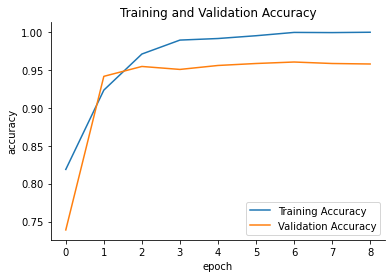

In [174]:
plt.plot(range(9), history['accuracy'], label='Training Accuracy')
plt.plot(range(9), history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
sns.despine()
plt.title('Training and Validation Accuracy')
plt.savefig("images/train_val_accuracy.png", dpi = 400, facecolor = "w", bbox_inches="tight");

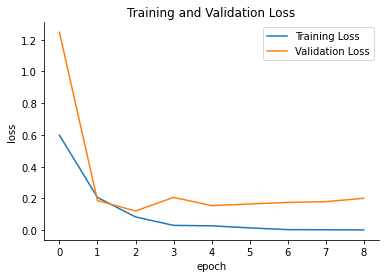

In [175]:
plt.plot(range(9), history['loss'], label='Training Loss')
plt.plot(range(9), history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
sns.despine()
plt.savefig("images/loss.png", dpi = 400, facecolor = "w", bbox_inches="tight");

In [11]:
pred_prob = model.predict(train_generator)

In [12]:
pred_prob

array([[0.02061474],
       [0.00592497],
       [0.05777565],
       ...,
       [0.99617296],
       [0.9880761 ],
       [0.9998454 ]], dtype=float32)

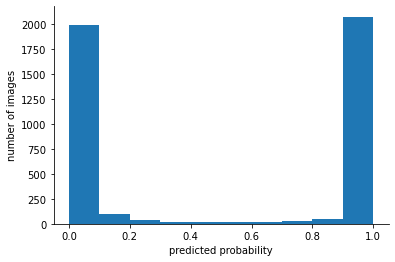

In [178]:
plt.hist(pred_prob)
plt.xlabel('predicted probability')
plt.ylabel('number of images')
sns.despine()
plt.savefig("images/probalilty_hist.png", dpi = 400, facecolor = "w", bbox_inches="tight");

In [13]:
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

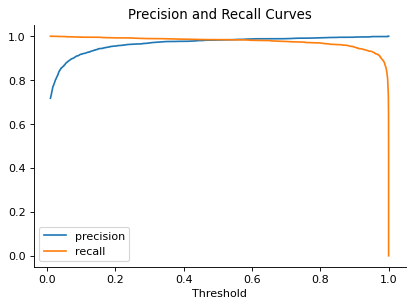

In [140]:
precision_curve, recall_curve, threshold_curve = metrics.precision_recall_curve(train_generator.classes, pred_prob)

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold')
plt.title('Precision and Recall Curves')
sns.despine()
plt.savefig("images/precision_recall_curve.png", dpi = 400, facecolor = "w", bbox_inches="tight");

ROC AUC score =  0.9981224825637975


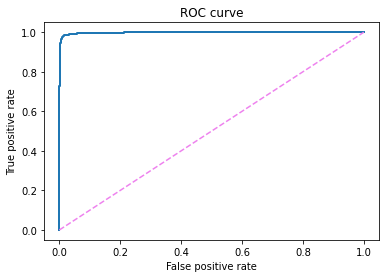

In [179]:
fpr, tpr, thresholds = metrics.roc_curve(train_generator.classes, pred_prob)
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.savefig("images/roc_curve.png", dpi = 400, facecolor = "w", bbox_inches="tight");
print("ROC AUC score = ", metrics.roc_auc_score(train_generator.classes, pred_prob))


In [16]:
for p in np.arange(0.3, 0.7, 0.01):
    print(p, metrics.fbeta_score(train_generator.classes, pred_prob>=p, beta = 1))

0.3 0.9788395904436861
0.31 0.9797312685037577
0.32 0.9801777170198223
0.33 0.9808481532147744
0.34 0.9815195071868583
0.35000000000000003 0.9817351598173517
0.36000000000000004 0.9815026261703584
0.37000000000000005 0.9812699862951119
0.38000000000000006 0.9812614259597807
0.39000000000000007 0.9814857142857142
0.4000000000000001 0.9814772467413675
0.4100000000000001 0.9814772467413675
0.4200000000000001 0.9812356979405035
0.4300000000000001 0.9814602883955139
0.4400000000000001 0.9823596792668957
0.4500000000000001 0.9823515929406372
0.46000000000000013 0.9825688073394494
0.47000000000000014 0.9830197338228547
0.48000000000000015 0.9830197338228547
0.49000000000000016 0.983011937557392
0.5000000000000002 0.9832376578645234
0.5100000000000002 0.9832376578645234
0.5200000000000002 0.9834634818557648
0.5300000000000002 0.9834634818557648
0.5400000000000003 0.983681912204091
0.5500000000000003 0.983681912204091
0.5600000000000003 0.9841342837433893
0.5700000000000003 0.984360625574977
0.

[[2138   38]
 [  35 2141]]


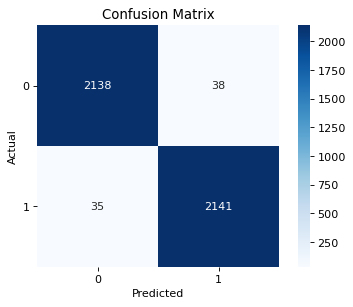

In [17]:
confusion = metrics.confusion_matrix(train_generator.classes, pred_prob >= 0.5)
print(confusion)
plt.figure(dpi=80)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.4g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.title('Confusion Matrix')
plt.savefig("images/train_confusion_matrix_50.png", dpi = 400, facecolor = "w", bbox_inches="tight");

In [146]:
metrics.f1_score(train_generator.classes, pred_prob >= 0.5)

0.9832376578645234

In [147]:
metrics.precision_score(train_generator.classes, pred_prob >= 0.5)

0.9825608077099587

In [148]:
metrics.recall_score(train_generator.classes, pred_prob >= 0.5)

0.9839154411764706

[[2148   28]
 [  38 2138]]


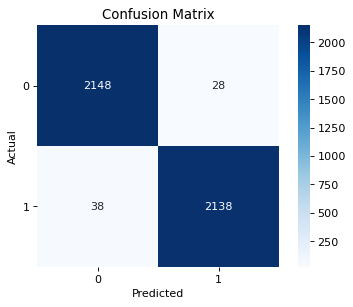

In [18]:
confusion = metrics.confusion_matrix(train_generator.classes, pred_prob >= 0.59)
print(confusion)
plt.figure(dpi=80)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.4g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.title('Confusion Matrix')
plt.savefig("images/train_confusion_matrix_59.png", dpi = 400, facecolor = "w", bbox_inches="tight");

In [149]:
metrics.f1_score(train_generator.classes, pred_prob >= 0.59)

0.9847996315062183

In [150]:
metrics.precision_score(train_generator.classes, pred_prob >= 0.59)

0.987072945521699

In [151]:
metrics.recall_score(train_generator.classes, pred_prob >= 0.59)

0.9825367647058824

In [19]:
(4352-28-38)/4352

0.9848345588235294

In [20]:
val_prob = model.predict(val_generator)
val_prob

array([[0.00347859],
       [0.00353584],
       [0.00287205],
       ...,
       [0.99999094],
       [0.99002784],
       [0.54114234]], dtype=float32)

[[728  40]
 [ 30 738]]


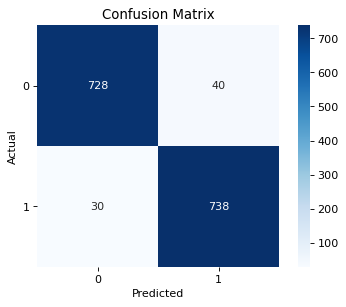

In [21]:
confusion = metrics.confusion_matrix(val_generator.classes, val_prob >= 0.5)
print(confusion)
plt.figure(dpi=80)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.4g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.title('Confusion Matrix')
plt.savefig("images/val_confusion_matrix_50.png", dpi = 400, facecolor = "w", bbox_inches="tight");

In [155]:
metrics.f1_score(val_generator.classes, val_prob >= 0.5)

0.9547218628719276

In [156]:
metrics.precision_score(val_generator.classes, val_prob >= 0.5)

0.9485861182519281

In [157]:
metrics.recall_score(val_generator.classes, val_prob >= 0.5)

0.9609375

[[736  32]
 [ 33 735]]


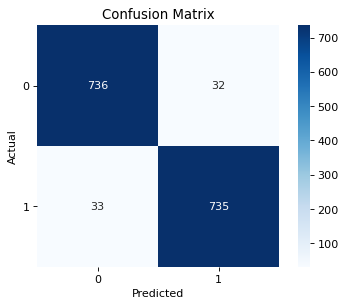

In [22]:
confusion = metrics.confusion_matrix(val_generator.classes, val_prob >= 0.59)
print(confusion)
plt.figure(dpi=80)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.4g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.title('Confusion Matrix')
plt.savefig("images/val_confusion_matrix_59.png", dpi = 400, facecolor = "w", bbox_inches="tight");

In [23]:
(1536-32-33)/1536

0.9576822916666666

In [152]:
metrics.f1_score(val_generator.classes, val_prob >= 0.59)

0.9576547231270359

In [153]:
metrics.precision_score(val_generator.classes, val_prob >= 0.59)

0.9582790091264668

In [154]:
metrics.recall_score(val_generator.classes, val_prob >= 0.59)

0.95703125

# Test data

In [24]:
model.evaluate(test_generator)

48/48 [==============================] - 184s 4s/step - loss: 0.0989 - accuracy: 0.9616


[0.09890925884246826, 0.9615885615348816]

In [25]:
test_prob = model.predict(test_generator)
test_prob

array([[0.00376031],
       [0.01181898],
       [0.00530666],
       ...,
       [0.99998176],
       [0.99695134],
       [0.9976724 ]], dtype=float32)

[[732  36]
 [ 23 745]]


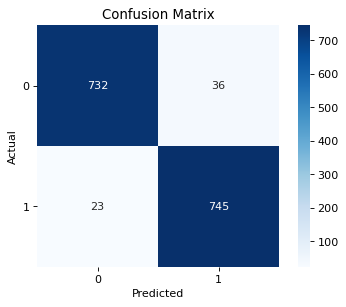

In [26]:
confusion = metrics.confusion_matrix(test_generator.classes, test_prob >= 0.5)
print(confusion)
plt.figure(dpi=80)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.3g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.title('Confusion Matrix')

plt.savefig("images/test_confusion_matrix_50.png", dpi = 400, facecolor = "w", bbox_inches="tight");

[[736  32]
 [ 28 740]]


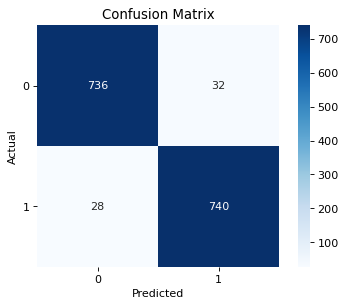

In [27]:
confusion = metrics.confusion_matrix(test_generator.classes, test_prob >= 0.59)
print(confusion)
plt.figure(dpi=80)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.3g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.title('Confusion Matrix')
plt.savefig("images/test_confusion_matrix_59.png", dpi = 400, facecolor = "w", bbox_inches="tight");

In [28]:
#accuracy
(1536-32-28)/1536

0.9609375

In [138]:
#precision
740/(740+32)

0.9585492227979274

In [137]:
#recall
740/(740+28)

0.9635416666666666

In [145]:
#F1-score
740/(740+(28+32)/2)

0.961038961038961

In [139]:
#F1-score
740/(740+32) * 740/(740+28) / (740/(740+32) + 740/(740+28)) * 2

0.961038961038961

# Security Camera

In [29]:
door_generator = testgen.flow_from_directory(
        'door_picture/',  
        target_size=(224, 224), 
        batch_size=32,
        seed=11,
        shuffle=False,
        color_mode='rgb',
        class_mode='binary') 

Found 10 images belonging to 2 classes.


In [30]:
model.evaluate(door_generator)

1/1 [==============================] - 0s 443ms/step - loss: 0.7510 - accuracy: 0.7000


[0.7509773969650269, 0.699999988079071]

In [31]:
images, labels = next(door_generator)
print(images.shape)
print(labels.shape)

(10, 224, 224, 3)
(10,)


In [46]:
prediction = (model.predict(door_generator) >= 0.34).astype(int).reshape(-1,)
prediction

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1])

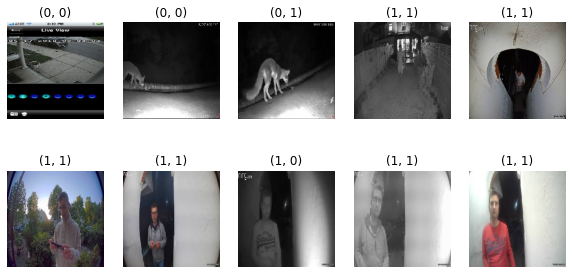

In [183]:
plt.figure(figsize=(10, 5))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title((int(labels[i]), prediction[i]))
    plt.axis("off")

# Crowd Count

In [114]:
img_size = 224
divided_h = 2
divided_w = 6

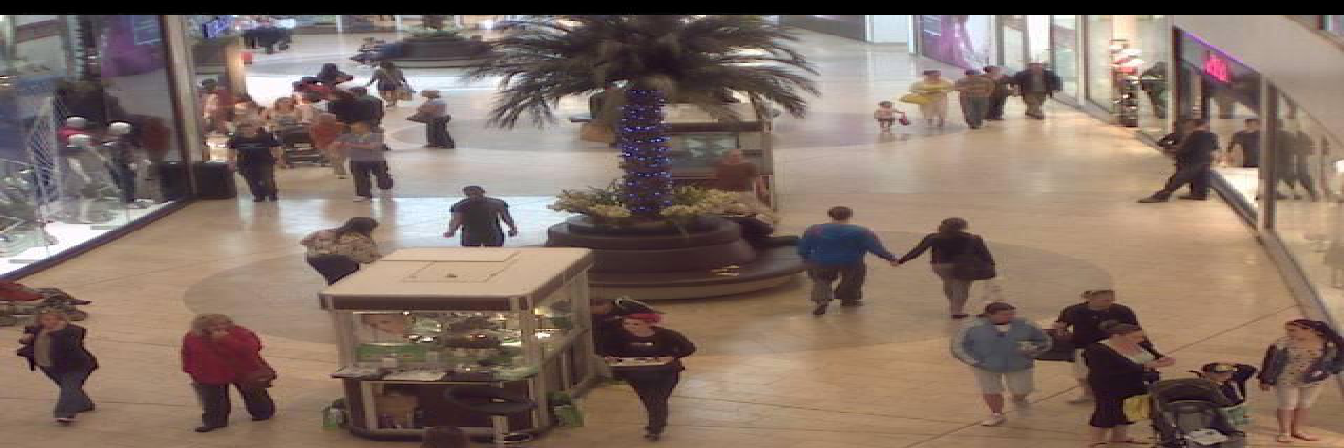

In [115]:
img = load_img('crowd_counting/frames/train/seq_000006.jpg', target_size = (img_size*divided_h, img_size*divided_w))
img

In [99]:
im = np.array(img)

In [124]:
c = 4
r = 16
C = (im.shape[0]-224)//c
R = (im.shape[1]-224)//r
tiles = [im[x:x+224,y:y+224] for x in range(0,im.shape[0]-223, C) for y in range(0,im.shape[1]-223, R)]

In [125]:
len(tiles)

85

In [126]:
pred = model.predict(np.array(tiles)/255) >= 0.59
pred.sum()

40

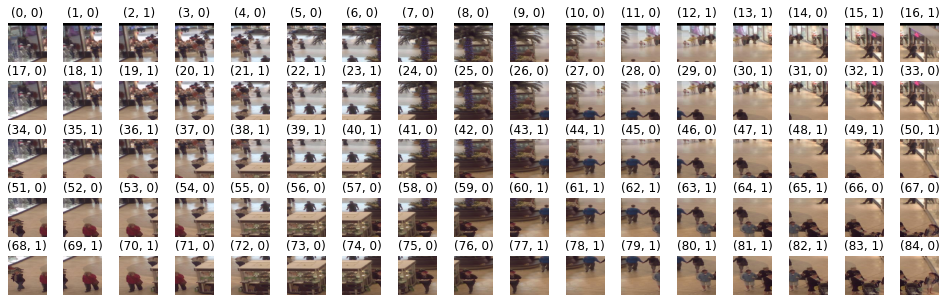

In [127]:
plt.figure(figsize=(r+1, c+1))
for i in range((r+1)*(c+1)):
    plt.subplot(c+1, r+1, i+1)
    plt.subplots_adjust(wspace = .0001, hspace= .5)
    plt.imshow(tiles[i])
    plt.title((i, int(pred[i])))
    plt.axis("off")

In [494]:
img_list = os.listdir('crowd_counting/frames/train/')
df_count = pd.DataFrame(columns = ['id', 'count'])
idx = 0
for file in img_list:
    if file != ".DS_Store":
        img = load_img(f'crowd_counting/frames/train/{file}', target_size = (img_size*divided_h, img_size*divided_w))
        im = np.array(img)
        C = (im.shape[0]-224)//4
        R = (im.shape[1]-224)//16
        tiles = [im[x:x+224,y:y+224] for x in range(0,im.shape[0]-223, C) for y in range(0,im.shape[1]-223, R)]
        preds = model.predict(np.array(tiles)/255) >= 0.59
        df_count.loc[idx] = [int(file[-8:-4]) ,preds.sum()]
        idx += 1

In [60]:
df_real = pd.read_csv('crowd_counting/labels.csv')

In [495]:
df = pd.merge(df_count, df_real, on='id')

In [496]:
df.count_x = df.count_x.astype('int')

In [509]:
df.corr()

,count_x,count_y
count_x,1.000000,0.357956
count_y,0.357956,1.000000


In [510]:
df.count_x.mean()

31.13963963963964

In [511]:
df.count_y.mean()

31.187258687258687

In [512]:
df

,id,count_x,count_y
0,1642,34,37
1,1124,28,30
2,1130,23,29
3,1656,38,47
4,548,28,17
...,...,...,...
1549,1897,25,27
1550,1129,37,35
1551,237,27,36
1552,223,41,38


In [502]:
reg = LinearRegression()

In [503]:
reg.fit(np.array(df['count_x']).reshape(-1, 1), df.count_y)

LinearRegression()

In [504]:
reg.score(np.array(df['count_x']).reshape(-1, 1), df.count_y)

0.12813254995046197

In [505]:
metrics.r2_score(df.count_y, reg.predict(np.array(df['count_x']).reshape(-1, 1)))

0.12813254995046197

In [506]:
metrics.mean_absolute_error(df.count_y,reg.predict(np.array(df['count_x']).reshape(-1, 1)))

5.203967974103535

In [521]:
metrics.mean_absolute_error(df.count_y, df.count_x)

6.164736164736165

In [58]:
img_list = os.listdir('crowd_counting/frames/test/')
df_count = pd.DataFrame(columns = ['id', 'count'])
idx = 0
for file in img_list:
    if file != ".DS_Store":
        img = load_img(f'crowd_counting/frames/test/{file}', target_size = (img_size*divided_h, img_size*divided_w))
        im = np.array(img)
        C = (im.shape[0]-224)//4
        R = (im.shape[1]-224)//16
        tiles = [im[x:x+224,y:y+224] for x in range(0,im.shape[0]-223, C) for y in range(0,im.shape[1]-223, R)]
        preds = model.predict(np.array(tiles)/255) >= 0.59
        df_count.loc[idx] = [int(file[-8:-4]) ,preds.sum()]
        idx += 1

In [61]:
df_test = pd.merge(df_count, df_real, on='id')

In [64]:
df_test.count_x = df_test.count_x.astype('int')

In [65]:
df_test

,id,count_x,count_y
0,560,26,22
1,1118,27,26
2,1865,25,32
3,38,27,25
4,992,31,43
...,...,...,...
441,1459,34,32
442,586,30,23
443,1667,18,25
444,551,32,29


In [66]:
metrics.mean_absolute_error(df_test.count_y, df_test.count_x)

6.762331838565022

In [67]:
df_test.count_x.mean()

30.739910313901344

In [68]:
df_test.count_y.mean()

31.053811659192824

In [69]:
(1554 * 6.164736164736165 + 446 * 6.762331838565022) / (1554 + 446)

6.298

In [70]:
(1554 * 31.13963963963964 + 446 * 30.739910313901344) / (1554 + 446)

31.0505

In [71]:
(1554 * 31.187258687258687 + 446 * 31.053811659192824) / (1554 + 446)

31.1575